<a href="https://colab.research.google.com/github/Manwa94/NLP_Application/blob/main/NLP_Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
num_gpus_available=len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available:",num_gpus_available)
assert num_gpus_available>0

sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
os.environ["CUDA_VISIBLE_DEVICES"]='0'

Num GPUs Available: 1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [2]:
#install Neccessary libraries
!pip install gradio
!pip install transformers
!pip install tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# New Section

In [4]:
dataset=tfds.load('amazon_us_reviews/Mobile_Electronics_v1_00',split='train',shuffle_files=True)

In [5]:
#Convert the dataset to pandas dataframe
dataset=tfds.as_dataframe(dataset)
dataset.head()

,data/customer_id,data/helpful_votes,data/marketplace,data/product_category,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_date,data/review_headline,data/review_id,data/star_rating,data/total_votes,data/verified_purchase,data/vine
0,b'20980074',0,b'US',b'Mobile_Electronics',b'B00D1847NE',b'274617424',b'Teenage Mutant Ninja Turtles Boombox CD Play...,b'Does not work',b'2015-01-09',b'One Star',b'R1OVS0D6SEXPW7',1,0,0,1
1,b'779273',0,b'US',b'Mobile_Electronics',b'B00KMO6DYG',b'397452138',b'4 Gauge Amp Kit Amplifier Install Wiring Com...,b'This is a great wiring kit i used it to set ...,b'2015-08-06',b'Great kit',b'R9VSD0ET8FERB',4,0,0,1
2,b'15410531',0,b'US',b'Mobile_Electronics',b'B000GWLL0K',b'948304826',b'Travel Wall Charger fits Creative Zen Vision...,b'It works great so much faster than USB charg...,b'2007-03-15',b'A/C Charger for Creative Zen Vision M',b'R3ISXCZHWLJLBH',5,0,0,1
3,b'27389005',0,b'US',b'Mobile_Electronics',b'B008L3JE6Y',b'466340015',b'High Grade Robust 360\xc2\xb0 Adjustable Car...,b'This product was purchased to hold a monitor...,b'2013-07-30',b'camera stand',b'R1TWVUDOFJSQAW',5,0,0,1
4,b'2663569',0,b'US',b'Mobile_Electronics',b'B00GHZS4SC',b'350592810',b'HDE Multifunctional Bluetooth FM Audio Car K...,"b""it works but it has really bad sound quality...",b'2014-12-31',b'bad sound quality',b'R2PEOEUR1LP0GH',3,0,0,1


In [6]:
#Pick the relevant columns of interest
columns_of_interest=['data/review_body','data/star_rating']
data=dataset[columns_of_interest]
data.head()

,data/review_body,data/star_rating
0,b'Does not work',1
1,b'This is a great wiring kit i used it to set ...,4
2,b'It works great so much faster than USB charg...,5
3,b'This product was purchased to hold a monitor...,5
4,"b""it works but it has really bad sound quality...",3


In [7]:
#Get the number of samples
print("Total Number of datapoints:",data.shape[0])

Total Number of datapoints: 104975


In [8]:
#Get the number of class(we will converts this the rating to sentiment in the next stage)
print ("Number of classess:",data['data/star_rating'].nunique())

Number of classess: 5


In [9]:
#Get the number of samples per class
print("Number of sample per class:",data['data/star_rating'].value_counts())

Number of sample per class: 5    52255
4    18088
1    17587
3     9734
2     7311
Name: data/star_rating, dtype: int64


In [10]:
#Get the number of words per sample
print("Number of words per sample:",np.mean(data['data/review_body'].apply(lambda x: len(x.split()))))

Number of words per sample: 63.97938556799238


In [11]:
#Get the distributed of number of words per sample
print("Distributed of number of words per sample:")
pd.DataFrame([len(s) for s in data['data/review_body']]).value_counts()

Distributed of number of words per sample:


9        550
114      534
115      523
113      522
119      518
        ... 
2724       1
2729       1
2731       1
2732       1
16009      1
Length: 3079, dtype: int64

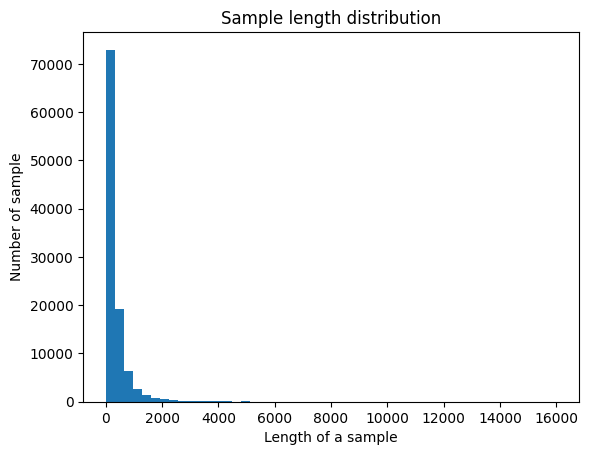

In [12]:
#Plot the distributed of sample length
def plot_sample_length_distribution(sample_texts):

   
  plt.hist([len(s) for s in sample_texts],50)
  plt.xlabel('Length of a sample')
  plt.ylabel('Number of sample')
  plt.title('Sample length distribution')
  plt.show()
plot_sample_length_distribution(data['data/review_body'].tolist())

In [13]:
#Take a sample of 50% of the dataset for the purpose of demonstration
data=data.sample(frac=0.3,random_state=42)
data.head()

,data/review_body,data/star_rating
87666,"b""The motor spins and is not stationary. That ...",3
47509,b'Fake',1
69877,"b""Even though there are finally some silicone ...",5
11951,"b""Absolutely Wonderful: This product is every...",5
73562,"b""Love this Bluetooth speaker...easy setup, wo...",5


In [14]:
print("Number of dataPoints after sampling:",data.shape)

Number of dataPoints after sampling: (31492, 2)


In [15]:
#Convert the star rating to sentiment
data['sentiment']=data['data/star_rating'].apply(lambda rating:"positive" if rating >3 else "negative")
data.head()

,data/review_body,data/star_rating,sentiment
87666,"b""The motor spins and is not stationary. That ...",3,negative
47509,b'Fake',1,negative
69877,"b""Even though there are finally some silicone ...",5,positive
11951,"b""Absolutely Wonderful: This product is every...",5,positive
73562,"b""Love this Bluetooth speaker...easy setup, wo...",5,positive


In [16]:
#One-hot encode the target label
data['sentiment']=data['sentiment'].map({'positive':1,'negative':0})

#Drop the rating column
data.drop(columns=['data/star_rating'],inplace=True)
data.head()

,data/review_body,sentiment
87666,"b""The motor spins and is not stationary. That ...",0
47509,b'Fake',0
69877,"b""Even though there are finally some silicone ...",1
11951,"b""Absolutely Wonderful: This product is every...",1
73562,"b""Love this Bluetooth speaker...easy setup, wo...",1


In [17]:
#Preprocess the reviews
data.rename(columns={'data/review_body':'review'},inplace=True)
data['review']=data['review'].str.decode('utf-8')
data['review']=data['review'].apply(str.lower)
data['review']

data.head()

,review,sentiment
87666,the motor spins and is not stationary. that se...,0
47509,fake,0
69877,even though there are finally some silicone ca...,1
11951,absolutely wonderful: this product is everyth...,1
73562,"love this bluetooth speaker...easy setup, wond...",1


In [18]:
#Check the sample per class
data['sentiment'].value_counts()

1    21114
0    10378
Name: sentiment, dtype: int64

In [19]:
#Balance out the classes for the purpose of demonstration
positive=data[data['sentiment']==1].sample(n=7425,random_state=42)
negative=data[data['sentiment']==0]
train_data=pd.concat([positive,negative]).sample(frac=1.).reset_index(drop=True)
train_data['sentiment'].value_counts()

0    10378
1     7425
Name: sentiment, dtype: int64

In [20]:
#Sample reviews and its corresponding labels 
reviews=train_data['review'].tolist()
labels=train_data['sentiment'].tolist()

print("Sample reviews:")
print(reviews[10:16])
print("Corresponding labels:")
print(labels[10:16])

Sample reviews:
['holds you ipod perfectly! i put it in, and never took it back out!<br />i never came loose(i dont think it even can) and i dropped it a couple times and it did not break<br />9/10!', 'the product was shipped very promptly and the instructions were easy enough to follow.  the quality of the modulator leaves a lot to be desired though.  spend more money for a better product.', 'i thought apple had the touch screen technology down. this ipod touch screen is so unresponsive when playing audiobooks that it is almost unusable. multiple taps and presses sometimes fail to pause, play or fast forward. then, for no apparent reason it responds. or the multiple attempts result in the volume increasing etc. perhaps i bought a lemon, but with this low level of functionality i avoid using this aspect of the touch screen as much as possible. interestingly, the touch screen works fine for most other apps and functions. it is marginally better playing music.', 'not  in english  does no

In [21]:
#Split the data into train, test and validation split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(reviews,labels,test_size=.2,random_state=42)

In [23]:
#Number of train and test data
print("Number of train data points:",len(X_train))
print("Number of train labels:",len(y_train))
print("Number of test data points:",len(X_test))
print("Number of test labels:",len(y_train))

Number of train data points: 14242
Number of train labels: 14242
Number of test data points: 3561
Number of test labels: 14242


In [24]:
#Load the tokenizer
from transformers import DistilBertTokenizerFast
MODEL_NAME='distilbert-base-uncased-finetuned-sst-2-english'
tokenizer=DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

In [26]:
#Sample tokenization
print("Sentence:",X_train[0])
tokenizer(X_train[0],truncation=True,padding=True,max_length=256,return_tensors="tf")


Sentence: wishing that the cover holders did not cover volume buttons. the color was perfect, and the fit was good. just the elastic went right over the contol for the volume.


{'input_ids': <tf.Tensor: shape=(1, 38), dtype=int32, numpy=
array([[  101, 10261,  2008,  1996,  3104, 13304,  2106,  2025,  3104,
         3872, 11287,  1012,  1996,  3609,  2001,  3819,  1010,  1998,
         1996,  4906,  2001,  2204,  1012,  2074,  1996, 21274,  2253,
         2157,  2058,  1996,  9530,  3406,  2140,  2005,  1996,  3872,
         1012,   102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 38), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [29]:
#perform tokenization
MAX_LENGTH=256
train_encodings=tokenizer(X_train,
                          truncation=True,
                          padding=True,
                          return_tensors="tf",
                          max_length=MAX_LENGTH)
test_encodings=tokenizer(X_test,
                         truncation=True,
                         padding=True,
                         return_tensors="tf",
                         max_length=MAX_LENGTH)


In [30]:
#Convet the tokenizer to TF object
train_dataset=tf.data.Dataset.from_tensor_slices((dict(train_encodings),
                                                  y_train))
test_dataset=tf.data.Dataset.from_tensor_slices((dict(test_encodings),
                                                 y_test))

In [31]:
#Define the model-use pretrained distilbert model and specify the label
from transformers import TFDistilBertForSequenceClassification
model=TFDistilBertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    num_labels=2
)

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [32]:
#Specify the model optimizer
optimizer=tf.keras.optimizers.Adam(
    learning_rate=5e-5,
)

In [33]:
#Specify the loss function
loss_func=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [35]:
#Compile the model
model.compile(optimizer=optimizer, loss=loss_func,metrics=['accuracy'])

In [36]:
#Inspect the model
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [39]:
#define hyperparameters
BATCH_SIZE=16
NUM_EPOCHS=2

#Train the model
model.fit(train_dataset.shuffle(len(X_train)).batch(BATCH_SIZE),
          epochs=NUM_EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=test_dataset.shuffle(len(X_test)).batch(BATCH_SIZE)
          )

Epoch 1/2
891/891 [==============================] - 442s 461ms/step - loss: 0.2950 - accuracy: 0.8784 - val_loss: 0.2322 - val_accuracy: 0.9045
Epoch 2/2
891/891 [==============================] - 400s 449ms/step - loss: 0.1807 - accuracy: 0.9315 - val_loss: 0.2463 - val_accuracy: 0.9079


In [40]:
#Save the model
model.save_pretrained("tmp/sentiment_model")

In [41]:
#Preprocess the unseen data
unseen_data=data.sample(frac=0.05,random_state=42)
unseen_reviews=unseen_data['review'].tolist()

unseen_encodings=tokenizer(unseen_reviews,
                           padding=True,
                           truncation=True,
                           max_length=MAX_LENGTH,
                           return_tensors="tf")
y_unseen=unseen_data['sentiment'].tolist()

unseen_encodings=tf.data.Dataset.from_tensor_slices((dict(unseen_encodings),
                                                     y_unseen
                                                     ))

In [42]:
#Evaluate the model
model.evaluate(unseen_encodings.shuffle(len(unseen_reviews)).batch(BATCH_SIZE),
               return_dict=True,
               batch_size=BATCH_SIZE)

99/99 [==============================] - 15s 146ms/step - loss: 0.2247 - accuracy: 0.9156


{'loss': 0.22469839453697205, 'accuracy': 0.9155555367469788}

In [44]:
import gradio as gr

def predict(sentence):
  #Load model
  loaded_model=TFDistilBertForSequenceClassification.from_pretrained("/temp/sentiment_model")

  #Get the prediction
  predictin_input=tokenizer.encode(sentence,
                                   truncation=True,
                                   padding=True,
                                   return_tensors="tf")
  tf_output=loaded_model.predict(predict_input)[0]
  tf_prediction=tf.nn.softmax(tf_output,axis=1).numpy()[0]
  return ['negative','positive'][np.argmax(tf_prediction)]

  demo=gr.Interface(fn=predict,inputs="text",outputs="text",live=True)
  demo.launch()